# Latent heat flux at the surface ($\lambda E$)

$$
C_{soil} \frac{\partial T_{s}}{\partial t} = (1-\alpha) \cdot SW_d + LW_d - LW_u \ - H - \textcolor{red}{\lambda E} - G      \tag{1.2}
$$

- **Definition:** The rate of moisture transfer per unit area by turbulence.

- **Equation:**

$$
\lambda E = \frac{\rho L_v (q_s - q_a)}{r_h}        \tag{7.1}
$$

where $L_v$ is the latent heat of vaporization, $q_s$ and $q_a$ are the surface and air specific humidity.

- The resistance for latent heat flux is usually considered to be the same as $r_h$.

`````{admonition} Evapotranspiration ($T_r$) from vegetation
:class: tip
- 1st generation LSMs (e.g., Unified Noah LSM) assume that transpiration ($T_r$) from vegetation is considered in $\lambda E$ by adding one more resistance (stomatal resistance, $r_s$) onto Eq. 7.1,

$$
\lambda E = \frac{\rho L_v (q_s - q_a)}{r_h + \textcolor{red}{r_s}}        \tag{7.2}
$$

- From 2nd generation LSMs, $T_r$ is calculated separately (will be discussed in the later chapter)
<!-- ADD LINK !!!!!! -->
`````

<br>
<br>
<br>
<hr>

### Discussion of $q_s$

`````{admonition} What is $q_s$?
:class: danger

$$
\lambda E = \frac{\rho L_v (q_s - q_a)}{r_h}        \tag{7.1}
$$

- What is specific humidity at the land surface? 🤔
- No one really knows what it is meant to be... 🤯
- But, to calculate latent flux, one somehow defines a surface value for $q_s$.
`````

<br>


`````{admonition} An idea
:class: tip

- Let's approximate $q_s$ with $q_{sat}(T_s, P_s)$!

$$
\lambda E = \frac{\rho L_v (\textcolor{red}{q_{sat}(T_s, P_s)} - q_a)}{r_h}        \tag{7.3}
$$
`````


<br>

`````{admonition} But...
:class: danger
does it mean that evaporation is always unlimited, no matter how much soil moisture there is?

- Yes... 🤔
- So, we need to consider soil moisture ($\theta$) effect!

$$
\lambda E = \frac{\rho L_v (\textcolor{red}{\beta} q_{sat}(T_s, P_s) - q_a)}{r_h}        \tag{7.4}
$$

where $\beta$ is the moisture availability. $\beta$ is given as


<!-- $$
\beta = 
\begin{cases}
1 & \text{if } \theta \ge \theta_{fc} \\
\frac{1}{4} \left[ 1 - \cos \left( \frac{\theta}{\theta_{fc}} \pi \right)  \right] ^{2} & \text{if }  \theta < \theta_{fc}
\end{cases}     \tag{7.5}
$$ -->

<!-- JSBACH -->
$$
\beta = \textrm{max} \left[ \textcolor{red}{\frac{1}{4} \left( 1 - \cos \left( \frac{\theta}{\theta_{fc}} \pi \right)  \right) ^{2}} \textrm{, min} \left(1, \frac{q_a}{q_{sat}(T_s,P_s)} \right)    \right]        \tag{7.5}
$$

where $\theta_{fc}$ is the value of $\theta$ at field capacity.
`````

<br>

`````{admonition} What is the field capacity?

- $\theta$: Volumetric soil moisture [m<sup>3</sup>/m<sup>3</sup>]
<p style="margin: 0.5em 0;"></p>

- $\theta_{sat}$: $\theta$ at saturation. Soil pore is filled up with water fully. No more water can enter soil. Water is drained down rapidly.
<p style="margin: 0.5em 0;"></p>

- $\theta_{fc}$: Gravitation percolation starts to be smaller as water is attached to the soil through molecular or physical bonds.
<p style="margin: 0.5em 0;"></p>

- $\theta_{pwp}$: $\theta$ at permanent wilting point. The soil holds the water so strongly that 
  1) the plant is unable to apply enough force to extract the water from the soil.
  2) gravitational percolation stops.

<figure>
  <img src="../_static/images/latent_heat_flux_01.png" alt="Soil moisture">
  <figcaption>Figure 7.1. Diagram of soil moisture conditions.</figcaption>
</figure>

Please see section 2 in {cite:p}`seneviratne2010investigating` for more description.
`````

<br>
<br>
<hr>

##### $\beta$

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Typical values
THETA_SAT = 0.45  # m3/m3
THETA_FC  = 0.35  # m3/m3
THETA_PWP = 0.15  # m3/m3

$$
\beta = \textrm{max} \left[ \frac{1}{4} \left( 1 - \cos \left( \frac{\theta}{\theta_{fc}} \pi \right)  \right) ^{2} \textrm{, min} \left(1, \frac{q_a}{q_{sat}(T_s,P_s)} \right)    \right]        \tag{7.5}
$$

In [3]:
def calculate_moisture_availability(theta, Qa, q_sat):

    beta = 0.25 * (1 - np.cos(theta / THETA_FC * np.pi)) ** 2
    beta_limit = Qa / q_sat
    beta_limit = np.where(beta_limit > 1.0, 1.0, beta_limit)

    beta = np.where(beta > beta_limit, beta, beta_limit)
    beta = np.where(theta > THETA_FC, 1.0, beta)

    return beta


def calculate_q_sat(Ta, Pa):
    
    e_sat = 0.611 * np.exp(17.27 * (Ta - 273.15) / (Ta - 273.15 + 237.3)) * 1000  # Pa
    q_sat = 0.622 * e_sat / (Pa - e_sat)  # kg/kg

    return q_sat


In [4]:
# setup

Ta = 300 # K
Pa = 101300 # Pa
Qa = 0.002 # kg/kg

theta = np.linspace(0, THETA_SAT, 100)
q_sat = calculate_q_sat(Ta, Pa)

beta = calculate_moisture_availability(theta, Qa, q_sat)

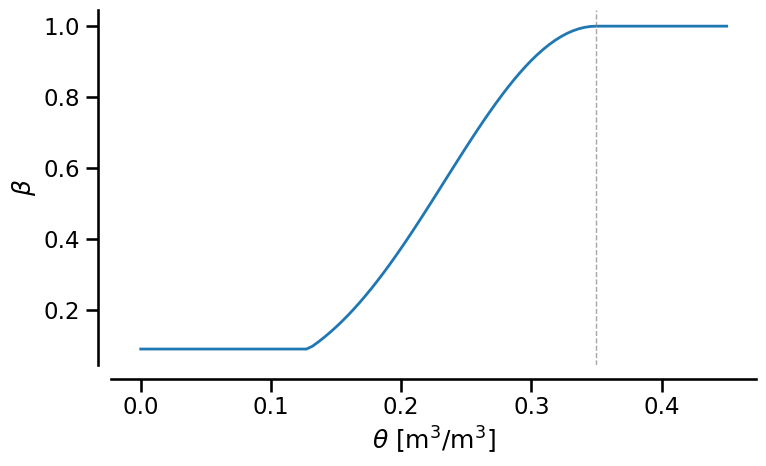

In [5]:
# plot
import seaborn as sns

sns.set_context('talk')
fig, ax = plt.subplots(figsize=(8, 5))

### moisture availability
ax.plot(theta, beta, linewidth=2, c='C0')
ax.set_xlabel(r'$\theta$ [m$^3$/m$^3$]', fontsize=18)
ax.set_ylabel(r'$\beta$', fontsize=18)

### Add vertical line at field capacity
ax.axvline(x=THETA_FC, color='gray', linewidth=1, linestyle='--', alpha=0.7,)

sns.despine(offset=10)
plt.tight_layout()

<br>
<br>
<br>
<hr>

### Practice 7.1
Diagnose $\lambda E$ using observed atmospheric variables at Daegu ASOS station in April 2012 for 1) $\theta=\theta_{fc}$ and 2) $\theta=0.2$. Assume that 

1) Observed variables contain $T_a$, $T_s$, $U$, $SW_d$
1) $z_r$ is 20 m
1) $z_0$ is 0.15 m

In [6]:
import xarray as xr
import pandas as pd
import function_package as fp

In [7]:
# Setup

dt = 3600 # s

# Make assumptions
zr = 20.0 # height of the model lowest layer [m]
z0 = 0.15 # roughness length [m]

LV = 2.501e6 # J/kg

In [9]:
# Get observation data

Ta, Ts, Pa, Qa, wind_speed, SWd, rho, R, ASOS_Daegu = fp.read_ASOS_at_Daegu('../data/ASOS_processed_2012033100-2012041000.nc', time_interval='original')

In [18]:
ASOS_Daegu

<xarray.Dataset> Size: 33kB
Dimensions:  (time: 97)
Coordinates:
  * time     (time) datetime64[ns] 776B 2012-04-01 ... 2012-04-05
    STN      float64 8B 143.0
Data variables: (12/45)
    WD       (time) float64 776B ...
    WS       (time) float64 776B ...
    GST      (time) float64 776B ...
    GST.1    (time) float64 776B ...
    GST.2    (time) float64 776B ...
    PA       (time) float64 776B 1.011e+03 1.012e+03 ... 1.004e+03 1.003e+03
    ...       ...
    BF       (time) float64 776B ...
    IR       (time) float64 776B ...
    IX       (time) float64 776B ...
    LON      float64 8B ...
    LAT      float64 8B ...
    Height   float64 8B ...
Attributes:
    CDI:          Climate Data Interface version 2.5.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Sun Jun 22 18:20:55 2025: cdo seldate,2012-03-31,2012-04-10...
    CDO:          Climate Data Operators version 2.5.0 (https://mpimet.mpg.de...

<br>
<br>

$$
\lambda E = \frac{\rho L_v (\beta q_{sat}(T_s, P_s) - q_a)}{r_h}        \tag{7.4}
$$

In [ ]:
# Calculate latent heat flux for theta=0.20
theta = 0.20        # m3/m3


time_dimension_size = len(Ts)

### Create an array for variables
ust    = np.zeros(time_dimension_size)
rh     = np.zeros(time_dimension_size)
H      = np.zeros(time_dimension_size)
LE_02 = np.zeros(time_dimension_size)
q_sat  = np.zeros(time_dimension_size)


from tqdm import tqdm
for n in tqdm(np.arange(1, time_dimension_size), desc='Calculating latent heat flux'):

    ### ①
    Rib = fp.calculate_bulk_richardson_number(Ts[n], Ta[n], Pa[n], wind_speed[n], zr)

    ### ②
    if Rib == 0.0:
        z_over_L = 0.0
    else:
        z_over_L = fp.calculate_z_over_L(Rib, zr, z0)

    ### ③
    z0_over_L  = z_over_L / zr * z0
    
    if Rib == 0.0:     # Neutral
        psi_m = 0.0
        psi_h = 0.0
    
    elif Rib > 0:      # Stable
        psi_m = fp.calculate_psim_stable(z_over_L) - fp.calculate_psim_stable(z0_over_L)
        psi_h = fp.calculate_psih_stable(z_over_L) - fp.calculate_psih_stable(z0_over_L)
    
    elif Rib < 0:      # Unstable
        psi_m = fp.calculate_psim_unstable(z_over_L) - fp.calculate_psim_unstable(z0_over_L)
        psi_h = fp.calculate_psih_unstable(z_over_L) - fp.calculate_psih_unstable(z0_over_L)

    ### ④
    zr_over_z0 = zr / z0
    ust[n] = fp.KARMAN * wind_speed[n] / (np.log(zr_over_z0) - psi_m)

    ### ⑤
    rh[n] = 1/(fp.KARMAN * ust[n]) * ( np.log(zr_over_z0) - psi_h )

    ### ⑥
    H[n]  = rho[n] * fp.C_P * (Ts[n] - Ta[n]) / rh[n]
    
    ### Latent heat flux
    q_sat[n]  = calculate_q_sat(Ts[n], fp.P_SFC)
    beta      = calculate_moisture_availability(theta, Qa[n], q_sat[n])
    LE_02[n] = rho[n] * LV * (beta*q_sat[n] - Qa[n]) / rh[n]

Calculating latent heat flux: 100%|██████████| 96/96 [00:01<00:00, 56.94it/s]


In [11]:
# Calculate latent heat flux for theta=theta_fc
theta = THETA_FC

time_dimension_size = len(Ts)

### Create an array for variables
ust    = np.zeros(time_dimension_size)
rh     = np.zeros(time_dimension_size)
H      = np.zeros(time_dimension_size)
LE_FC = np.zeros(time_dimension_size)
q_sat  = np.zeros(time_dimension_size)

from tqdm import tqdm
for n in tqdm(np.arange(1, time_dimension_size), desc='Calculating latent heat flux'):

    ### ①
    Rib = fp.calculate_bulk_richardson_number(Ts[n], Ta[n], Pa[n], wind_speed[n], zr)

    ### ②
    if Rib == 0.0:
        z_over_L = 0.0
    else:
        z_over_L = fp.calculate_z_over_L(Rib, zr, z0)

    ### ③
    z0_over_L  = z_over_L / zr * z0
    
    if Rib == 0.0:     # Neutral
        psi_m = 0.0
        psi_h = 0.0
    
    elif Rib > 0:      # Stable
        psi_m = fp.calculate_psim_stable(z_over_L) - fp.calculate_psim_stable(z0_over_L)
        psi_h = fp.calculate_psih_stable(z_over_L) - fp.calculate_psih_stable(z0_over_L)
    
    elif Rib < 0:      # Unstable
        psi_m = fp.calculate_psim_unstable(z_over_L) - fp.calculate_psim_unstable(z0_over_L)
        psi_h = fp.calculate_psih_unstable(z_over_L) - fp.calculate_psih_unstable(z0_over_L)

    ### ④
    zr_over_z0 = zr / z0
    ust[n] = fp.KARMAN * wind_speed[n] / (np.log(zr_over_z0) - psi_m)

    ### ⑤
    rh[n] = 1/(fp.KARMAN * ust[n]) * ( np.log(zr_over_z0) - psi_h )

    ### ⑥
    H[n]  = rho[n] * fp.C_P * (Ts[n] - Ta[n]) / rh[n]
    
    ### Latent heat flux
    q_sat[n]  = calculate_q_sat(Ts[n], fp.P_SFC)
    beta      = calculate_moisture_availability(theta, Qa[n], q_sat[n])
    LE_FC[n] = rho[n] * LV * (beta*q_sat[n] - Qa[n]) / rh[n]

Calculating latent heat flux: 100%|██████████| 96/96 [00:01<00:00, 56.77it/s]


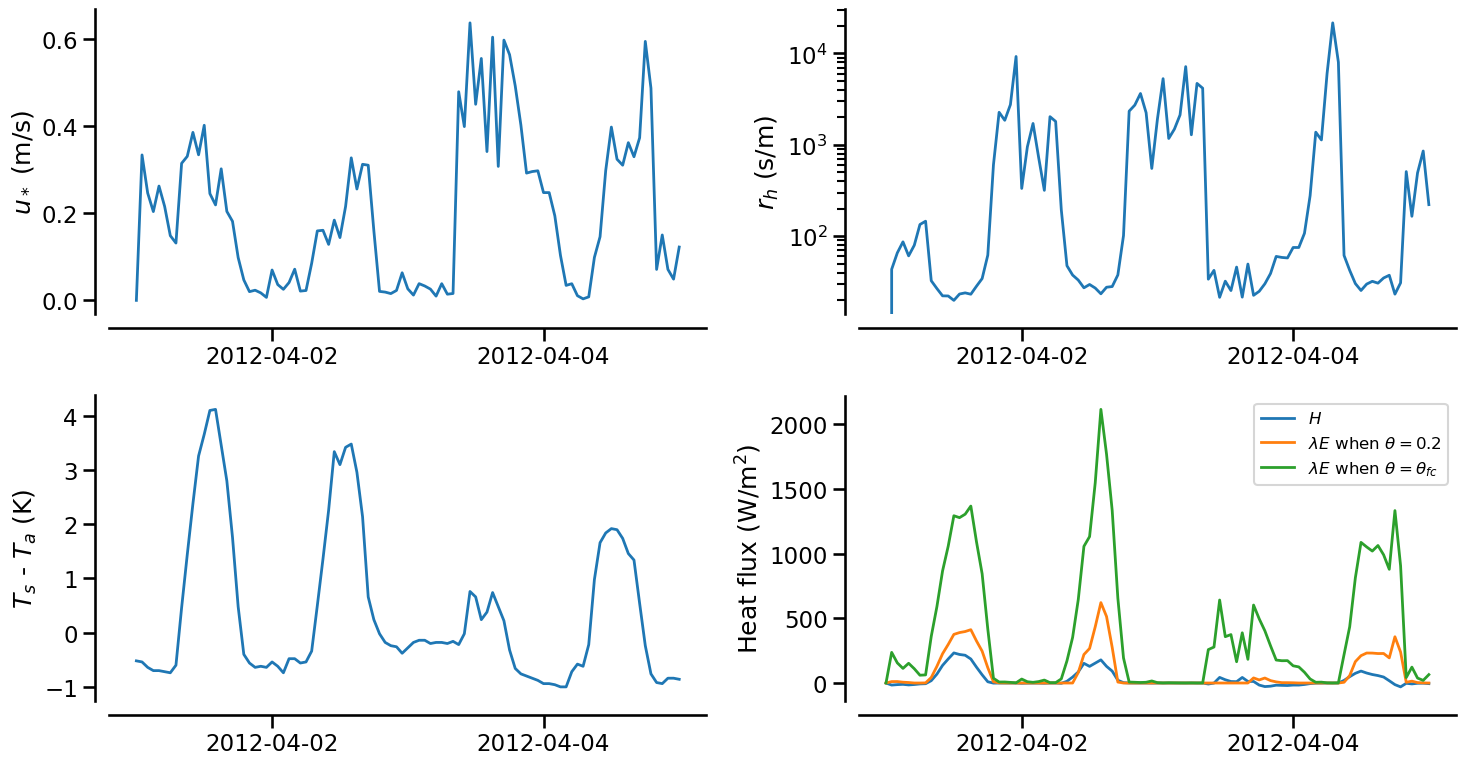

In [12]:
# plot

import matplotlib.dates as mdates

sns.set_context('talk')
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15, 8))

time_info = Ta['time'].values

### Friction velocity
ax[0,0].plot(time_info, ust, linewidth=2)
ax[0,0].set_ylabel('$u_*$ (m/s)', fontsize=18)

### Aerodynamic resistance
ax[0,1].plot(time_info, rh, linewidth=2)
ax[0,1].set_yscale('log')
ax[0,1].set_ylabel('$r_h$ (s/m)', fontsize=18)

### Temperature difference
ax[1,0].plot(time_info, Ts - Ta, linewidth=2)
ax[1,0].set_ylabel('$T_s$ - $T_a$ (K)', fontsize=18)

### Heat flux
ax[1,1].plot(time_info, H, linewidth=2, c='C0', label=r'$H$')
ax[1,1].set_ylabel('$H$ (W/m$^2$)', fontsize=18)

ax[1,1].plot(time_info, LE_02, linewidth=2, c='C1', label=r'$\lambda E$ when $\theta = 0.2$')
ax[1,1].set_ylabel('Heat flux (W/m$^2$)', fontsize=18)

ax[1,1].plot(time_info, LE_FC, linewidth=2, c='C2', label=r'$\lambda E$ when $\theta = \theta_{fc}$')
ax[1,1].set_ylabel('Heat flux (W/m$^2$)', fontsize=18)
ax[1,1].legend(fontsize=12)

### properties
for i in range(2):
    for j in range(2):
        ax[i,j].xaxis.set_major_locator(mdates.DayLocator(interval=2))

sns.despine(offset=10)
plt.tight_layout()

<br>
<br>
<br>
<hr>

### Practice 7.2

Predict $T_s$ at Daegu ASOS station in April 2012 using observed atmospheric variables with Eq. 7.4 for $\lambda E$. Assume that

1) Observed variables contain $T_a$, $U$, & $SW_d$
1) $z_r$ is 20 m
1) $z_0$ is 0.15 m
1) $T_s$ at initial time is set to observed $T_s$
1) $C_{soil}$ is $c_{soil} \cdot d_s$, where $c_{soil}$ is heat capacity of soil (2.0 $\times$ 10<sup>6</sup> J/m<sup>3</sup>/K) and $d_s$ is depth of soil (0.07 m)
1) $\alpha$ is 0.3
1) $LW_d$ is 400 W/m<sup>2</sup>
1) $G$ is 0 W/m<sup>2</sup>
1) $\theta$ is fixed at 0.2 m<sup>3</sup>/m<sup>3</sup>

&#8594; Predict $\textcolor{red}{T_s}$, $\textcolor{red}{LW_u}$, $\textcolor{red}{H}$, $\textcolor{red}{\lambda E}$ by prescribing $SW_d$, $LW_d$, $G$:

$$
C_{soil} \textcolor{red}{\frac{\partial T_{s}}{\partial t}} = (1-\alpha) \cdot SW_d + LW_d - \textcolor{red}{LW_u} - \textcolor{red}{H} - \textcolor{red}{\lambda E} - G       \tag{1.2}
$$



In [13]:
# Setup

dt = 60 # s 

# Make assumptions
LWd = 400       # W/m2
G   = 0.0       # W/m2
zr = 20.0 # height of the model lowest layer [m]
z0 = 0.15 # roughness length [m]

In [15]:
Ta, Ts, Pa, Qa, wind_speed, SWd, rho, R, ASOS_Daegu = fp.read_ASOS_at_Daegu('../data/ASOS_processed_2012033100-2012041000.nc', time_interval='1min')

In [ ]:
# Predict Ts
theta = 0.2     # m3/m3
time_dimension_size = len(Ts)

### Create an array for Ts
predicted_Ts  = np.zeros(time_dimension_size)
predicted_ust = np.zeros(time_dimension_size)
predicted_rh  = np.zeros(time_dimension_size)
predicted_H   = np.zeros(time_dimension_size)
predicted_LE  = np.zeros(time_dimension_size)
predicted_q_sat = np.zeros(time_dimension_size)

### Initial value of Ts
predicted_Ts[0] = Ts.isel(time=0).values

from tqdm import tqdm
for n in tqdm(np.arange(1, time_dimension_size), desc='Predicting surface temperature'):

    ### ①
    Rib = fp.calculate_bulk_richardson_number(predicted_Ts[n-1], Ta[n-1], Pa[n-1], wind_speed[n-1], zr)

    ### ②
    if Rib == 0.0:
        z_over_L = 0.0
    else:
        z_over_L = fp.calculate_z_over_L(Rib, zr, z0)

    ### ③
    z0_over_L  = z_over_L / zr * z0
    
    if Rib == 0.0:     # Neutral
        psi_m = 0.0
        psi_h = 0.0
    
    elif Rib > 0:      # Stable
        psi_m = fp.calculate_psim_stable(z_over_L) - fp.calculate_psim_stable(z0_over_L)
        psi_h = fp.calculate_psih_stable(z_over_L) - fp.calculate_psih_stable(z0_over_L)
    
    elif Rib < 0:      # Unstable
        psi_m = fp.calculate_psim_unstable(z_over_L) - fp.calculate_psim_unstable(z0_over_L)
        psi_h = fp.calculate_psih_unstable(z_over_L) - fp.calculate_psih_unstable(z0_over_L)

    ### ④
    zr_over_z0 = zr / z0
    ust = fp.KARMAN * wind_speed[n-1] / (np.log(zr_over_z0) - psi_m)
    predicted_ust[n] = ust

    ### ⑤
    rh = 1/(fp.KARMAN * ust) * ( np.log(zr_over_z0) - psi_h )
    predicted_rh[n] = rh

    ### ⑥
    H = rho[n-1] * fp.C_P * (predicted_Ts[n-1] - Ta[n-1]) / rh
    predicted_H[n] = H

    ### Latent heat flux
    predicted_q_sat[n]  = calculate_q_sat(predicted_Ts[n-1], fp.P_SFC)
    beta      = calculate_moisture_availability(theta, Qa[n-1], predicted_q_sat[n])
    LE        = rho[n-1] * LV * (beta*predicted_q_sat[n] - Qa[n-1]) / rh
    predicted_LE[n] = LE

    ### Upward longwave radiation
    LWu = fp.calculate_LWu(predicted_Ts[n-1])

    ### Surface temperature
    predicted_Ts[n] = predicted_Ts[n-1] + dt/fp.C_SOIL * ( (1-fp.ALBEDO) * SWd[n-1] + LWd - LWu - H - LE - G )


predicted_Ts = xr.DataArray(predicted_Ts, dims='time', coords={'time': Ts['time'].values},
                 attrs={'units': 'K',
                        'long_name': 'Predicted surface temperature'},)
predicted_Ts

Predicting surface temperature: 100%|██████████| 5760/5760 [02:16<00:00, 42.24it/s] 


<xarray.DataArray (time: 5761)> Size: 46kB
array([277.93      , 277.95883141, 277.98662715, ..., 286.505629  ,
       286.49722968, 286.4888683 ], shape=(5761,))
Coordinates:
  * time     (time) datetime64[ns] 46kB 2012-04-01 ... 2012-04-05
Attributes:
    units:      K
    long_name:  Predicted surface temperature

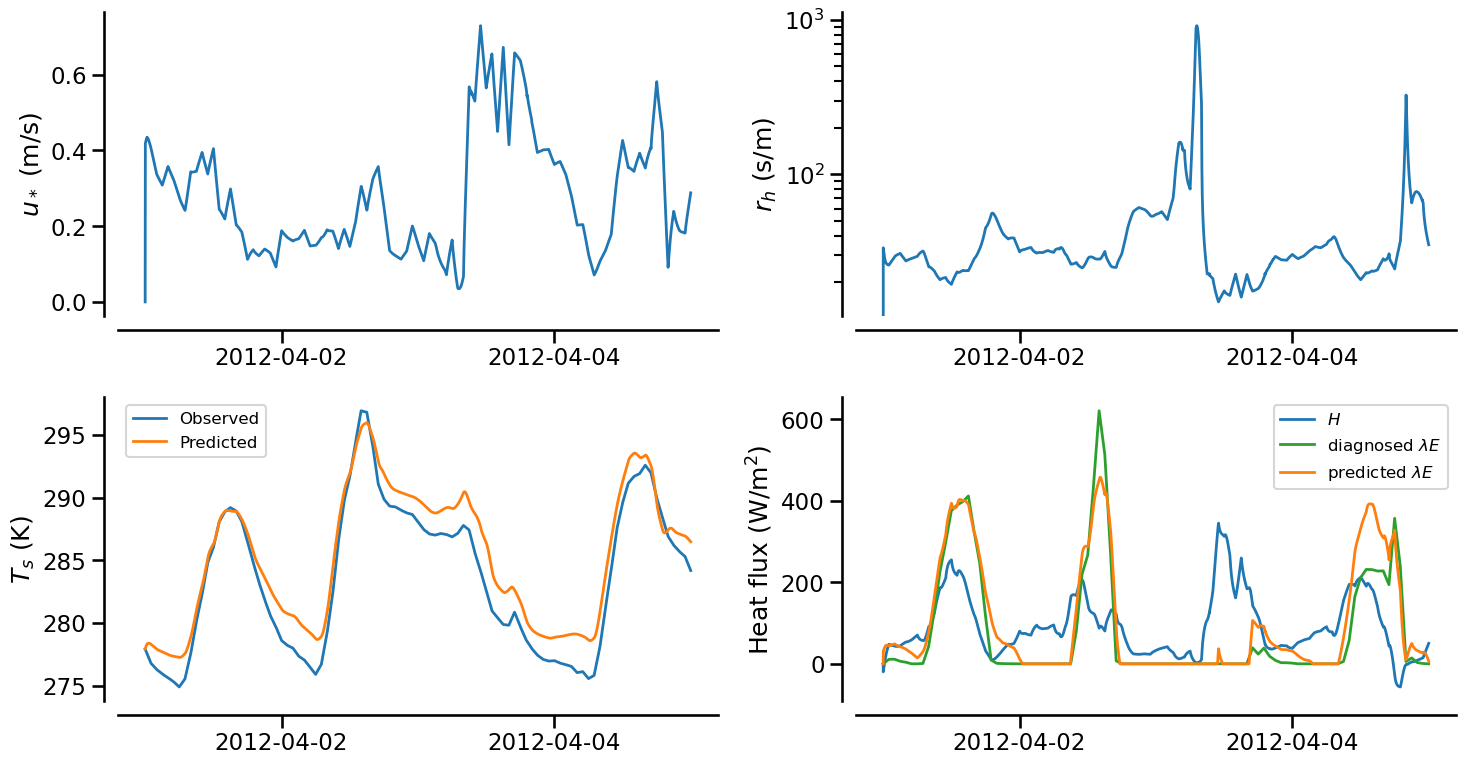

In [17]:
# plot

sns.set_context('talk')
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15, 8))

time_info = Ts['time'].values

### Friction velocity
ax[0,0].plot(time_info, predicted_ust, linewidth=2)
ax[0,0].set_ylabel('$u_*$ (m/s)', fontsize=18)

### Aerodynamic resistance
ax[0,1].plot(time_info, predicted_rh, linewidth=2)
ax[0,1].set_yscale('log')
ax[0,1].set_ylabel('$r_h$ (s/m)', fontsize=18)

### Surface temperature
ax[1,0].plot(time_info, Ts,           linewidth=2, c='C0', label='Observed')
ax[1,0].plot(time_info, predicted_Ts, linewidth=2, c='C1', label='Predicted')
ax[1,0].set_ylabel('$T_s$ (K)', fontsize=18)
ax[1,0].legend(fontsize=12)

### Heat flux
ax[1,1].plot(time_info, predicted_H,  linewidth=2, c='C0', label=r'$H$')
ax[1,1].plot(pd.date_range(start=Ta.time[0].item(), end=Ta.time[-1].item(), freq='1h'), LE_02, linewidth=2, c='C2', label=r'diagnosed $\lambda E$')
ax[1,1].plot(time_info, predicted_LE, linewidth=2, c='C1', label=r'predicted $\lambda E$')
ax[1,1].set_ylabel('Heat flux (W/m$^2$)', fontsize=18)
ax[1,1].legend(fontsize=12)

### properties
for i in range(2):
    for j in range(2):
        ax[i,j].xaxis.set_major_locator(mdates.DayLocator(interval=2))

sns.despine(offset=10)
plt.tight_layout()